In [1]:
import os
import pandas as pd

In [2]:
data = []
for folder in sorted(os.listdir('doc_dirr')):
    for file in sorted(os.listdir('doc_dirr/'+folder)):
        with open('doc_dirr/'+folder+'/'+file, 'r') as doc:
            content = doc.read().replace('\n', '')
        data.append((folder, file , content))
df = pd.DataFrame(data, columns=['category', 'file_name','content'])
print (df.head())

   category file_name                                            content
0  business   001.txt  Ad sales boost Time Warner profitQuarterly pro...
1  business   002.txt  Dollar gains on Greenspan speechThe dollar has...
2  business   003.txt  Yukos unit buyer faces loan claimThe owners of...
3  business   004.txt  High fuel prices hit BA's profitsBritish Airwa...
4  business   005.txt  Pernod takeover talk lifts DomecqShares in UK ...


In [3]:
df['category_id'] = df['category'].factorize()[0]

In [4]:
category_id_df = df[['category', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'category']].values)

In [5]:
category_id_df

,category,category_id
0,business,0
510,entertainment,1
896,politics,2
1313,sport,3
1824,tech,4


In [6]:
category_to_id

{'business': 0, 'entertainment': 1, 'politics': 2, 'sport': 3, 'tech': 4}

In [7]:
id_to_category

{0: 'business', 1: 'entertainment', 2: 'politics', 3: 'sport', 4: 'tech'}

In [8]:
import matplotlib.pyplot as plt
df.groupby('category').file_name.count().plot.bar(ylim=0)

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
features = tfidf.fit_transform(df.content).toarray()
labels = df.category_id
features.shape

(2225, 14316)

In [11]:
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import cross_val_score
models = [
  
   RandomForestClassifier(n_estimators=100),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

In [12]:
cv_df.groupby('model_name').accuracy.mean()

model_name
RandomForestClassifier    0.947473
Name: accuracy, dtype: float64

In [13]:
from sklearn.model_selection import train_test_split

model = RandomForestClassifier(n_estimators=100)

X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

Text(0.5, 15.0, 'Predicted')

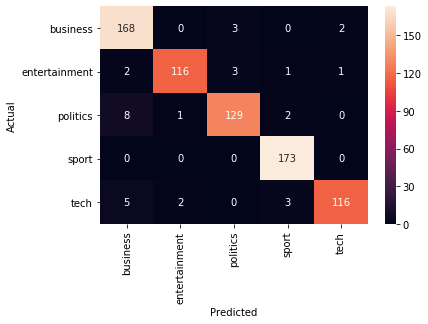

In [14]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

conf_mat = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.category.values, yticklabels=category_id_df.category.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')